In [59]:
import pandas as pd
import numpy as np
import acessos as ac
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data  = 'current_date'

In [10]:
query = f"""
 

 	select 
	b.cd_cpf
	, count(distinct case when dt_chat >= date_add('month', -12 , date_trunc('month', {data}) ) and dt_chat < date_trunc('month', {data}) then c.id_issue end) as contatos_12m
	, count(distinct case when dt_chat >= date_add('month', -6 , date_trunc('month', {data}) ) then c.id_issue end) as contatos_6m
	, max(dt_chat) as recencia_contato
	FROM customer_analytics_zone.ca_analitico_basao_crm b
    left join cx_curated_zone.cx_contact_rate c on (c.cpf_customer = b.cd_cpf)
	left join cx_curated_zone.helpshift_issues AS issues_macro ON c.id_issue = issues_macro.id_issue
	left join cx_curated_zone.helpshift_tag_niveis AS helpshift_tag ON c.id_issue = helpshift_tag.id_issue
	group by 1
    order by rand()
    limit 500000

"""

In [11]:
base = ac.df_athena('flavia-costa', query)

In [12]:
len(base)

500000

In [25]:
base.dtypes

cd_cpf                      object
contatos_12m                 int64
contatos_6m                  int64
recencia_contato    datetime64[ns]
dtype: object

In [24]:
base['recencia_contato'] = pd.to_datetime(base['recencia_contato'])

In [26]:
base['recencia_dias_contato'] = (datetime.now() - base['recencia_contato']).dt.days

In [32]:
base.head()

,cd_cpf,contatos_12m,contatos_6m,recencia_contato,recencia_dias_contato
0,05312049360,1,1,2023-04-05,134.0
1,39318402805,0,0,NaT,1640.0
2,07471326409,1,1,2023-03-13,157.0
3,16287704659,3,0,2022-12-28,232.0
4,86451091588,0,0,NaT,1640.0


In [31]:
base['contatos_12m'] = base['contatos_12m'].fillna(0)
base['contatos_6m'] = base['contatos_6m'].fillna(0)
base['recencia_dias_contato'] = base['recencia_dias_contato'].fillna(base.recencia_dias_contato.max())

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features_cluster = ['contatos_12m','contatos_6m', 'recencia_dias_contato']
base_cluster = base[features_cluster]

scaler = StandardScaler()
scaler_model = scaler.fit(base_cluster)
data_input_scaled = scaler_model.transform(base_cluster)

kmeans = KMeans(n_clusters = 5, random_state=0).fit(data_input_scaled)
cluster = kmeans.predict(data_input_scaled)
base['cluster'] = cluster

base['cluster'].value_counts()

0    227258
3    179101
1     73472
4     17810
2      2359
Name: cluster, dtype: int64

In [41]:
base['cluster'].value_counts(normalize = True)

0    0.454516
3    0.358202
1    0.146944
4    0.035620
2    0.004718
Name: cluster, dtype: float64

In [42]:
base.groupby('cluster')[features_cluster].mean()

,contatos_12m,contatos_6m,recencia_dias_contato
cluster,,,
0,0.000000,0.000000,1601.338602
1,3.948783,2.339449,93.828860
2,22.626537,17.567189,32.317931
3,0.868694,0.343008,324.628076
4,9.940090,6.699382,56.601684


In [46]:
base.groupby('cluster')[features_cluster].median()

,contatos_12m,contatos_6m,recencia_dias_contato
cluster,,,
0,0.0,0.0,1640.0
1,3.0,2.0,81.0
2,20.0,16.0,21.0
3,1.0,0.0,295.0
4,9.0,6.0,42.0


In [47]:
base.query('contatos_12m > 0')[features_cluster].describe()

,contatos_12m,contatos_6m,recencia_dias_contato
count,200790.000000,200790.000000,200790.000000
mean,3.367289,1.900682,145.998212
std,3.780421,2.845574,108.959031
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,49.000000
50%,2.000000,1.000000,122.000000
75%,4.000000,2.000000,232.000000
max,136.000000,85.000000,381.000000


In [48]:
base[features_cluster].quantile(0.95)

contatos_12m                7.0
contatos_6m                 4.0
recencia_dias_contato    1640.0
Name: 0.95, dtype: float64

In [ ]:
#p50, p75 e p95 - eixo de frequencia baseado nos 6 meses

#60, 120 e 180 eixo de recencia

#analisar desaceleração 6 x 12 meses

In [77]:
base['desaceleracao_contato'] = np.where(base['contatos_12m'] == 0, 'sem contato 12m',
                                np.where((base['contatos_6m'] == 0) & (base['contatos_12m'] > 0), 'diminuiram contato nos 6m',
                                np.where(base['contatos_6m'] >= (base['contatos_12m']-base['contatos_6m']), 'aumentaram  ou mantiveram contato nos 6m',
                                np.where(base['contatos_6m'] < (base['contatos_12m']-base['contatos_6m']), 'diminuiram contato nos 6m',
                                'ni'))))

base.head()

,cd_cpf,contatos_12m,contatos_6m,recencia_contato,recencia_dias_contato,cluster,desaceleracao_contato
0,05312049360,1,1,2023-04-05,134.0,3,aumentaram ou mantiveram contato nos 6m
1,39318402805,0,0,NaT,1640.0,0,sem contato 12m
2,07471326409,1,1,2023-03-13,157.0,3,aumentaram ou mantiveram contato nos 6m
3,16287704659,3,0,2022-12-28,232.0,3,diminuiram contato nos 6m
4,86451091588,0,0,NaT,1640.0,0,sem contato 12m


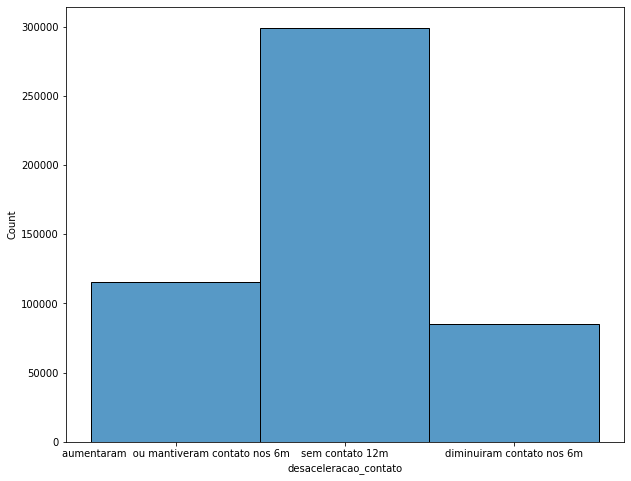

In [78]:
plt.figure(figsize = (10,8))
sns.histplot(data = base, x = 'desaceleracao_contato')
plt.show()

In [81]:
base['desaceleracao_contato'].value_counts(normalize = True)

sem contato 12m                             0.598420
aumentaram  ou mantiveram contato nos 6m    0.230672
diminuiram contato nos 6m                   0.170908
Name: desaceleracao_contato, dtype: float64

In [80]:
base[['contatos_12m','contatos_6m', 'cd_cpf']].groupby(['contatos_12m','contatos_6m']).count()['cd_cpf'].nlargest(10)

contatos_12m  contatos_6m
0             0              290649
1             1               38955
              0               33540
2             2               15780
              0               13778
              1                8905
3             3                7798
              0                6814
0             1                6353
3             1                4442
Name: cd_cpf, dtype: int64

In [82]:
#p50, p75 e p95 - eixo de frequencia baseado nos 6 meses

In [96]:
base['segmentacao_contatos'] = np.where(base['contatos_6m'] == 0, 'A - Sem contato 6m',
                            np.where(base['contatos_6m'] == 1, 'B - Apenas um contato 6m',
                            np.where(base['contatos_6m'] == 2, 'C - Dois contatos 6m',
                            np.where((base['contatos_6m'] == 3) | (base['contatos_6m'] == 4), 'D - Tres a quatro contatos 6m',
                            np.where(base['contatos_6m'] > 4, 'E - Cinco ou mais contatos 6m', 'NI')))))

In [97]:
base['segmentacao_contatos'].value_counts(normalize = True)

A - Sem contato 6m               0.709316
B - Apenas um contato 6m         0.132322
C - Dois contatos 6m             0.061086
D - Tres a quatro contatos 6m    0.053428
E - Cinco ou mais contatos 6m    0.043848
Name: segmentacao_contatos, dtype: float64

In [98]:
base = base.rename(columns={'contatos_12m' : 'nr_contatos_cx_12m', 'contatos_6m' : 'nr_contatos_cx_6m', 'recencia_dias_contato' : 'nr_dias_ultimo_contato', 'desaceleracao_contato' : 'ds_classif_desaceleracao_contato', 'segmentacao_contatos' : 'ds_classif_cx_contatos'})

In [99]:
base.head()

,cd_cpf,nr_contatos_cx_12m,nr_contatos_cx_6m,recencia_contato,nr_dias_ultimo_contato,cluster,ds_classif_desaceleracao_contato,ds_classif_cx_contatos
0,05312049360,1,1,2023-04-05,134.0,3,aumentaram ou mantiveram contato nos 6m,B - Apenas um contato 6m
1,39318402805,0,0,NaT,1640.0,0,sem contato 12m,A - Sem contato 6m
2,07471326409,1,1,2023-03-13,157.0,3,aumentaram ou mantiveram contato nos 6m,B - Apenas um contato 6m
3,16287704659,3,0,2022-12-28,232.0,3,diminuiram contato nos 6m,A - Sem contato 6m
4,86451091588,0,0,NaT,1640.0,0,sem contato 12m,A - Sem contato 6m
